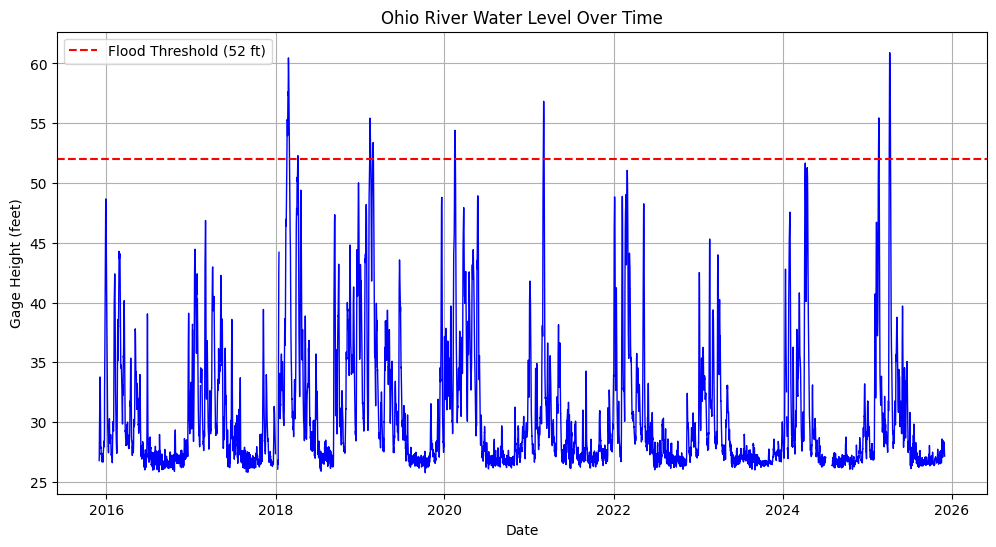

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'nwis.waterservices.usgs.gov.txt'
column_names = ['agency_cd', 'site_no', 'datetime', 'tz_cd', 'gage_height', 'qualification_code']
df = pd.read_csv(file_path, sep='\t', names=column_names, comment='#')

df['gage_height'] = pd.to_numeric(df['gage_height'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df_resampled = df.resample('1h', on='datetime').mean(numeric_only=True).reset_index()
df=df_resampled

plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['gage_height'], color='blue', linewidth=1)
plt.axhline(y=52, color='red', linestyle='--', label='Flood Threshold (52 ft)')
plt.title('Ohio River Water Level Over Time')
plt.xlabel('Date')
plt.ylabel('Gage Height (feet)')
plt.legend()
plt.grid(True)
plt.show()


# Phase 2: Feature Engineering & Modeling

In [2]:
df = df.sort_values('datetime')

lookback_steps = 24
lags = [df['gage_height'].shift(i).rename(f'lag_{i}') for i in range(1, lookback_steps + 1)]

target = df['gage_height'].shift(-24).rename('target_height')
df_ml = pd.concat([df] + lags + [target], axis=1)

df_ml = df_ml.dropna().copy()

print(f"Data ready without warnings! New shape: {df_ml.shape}")

Data ready without warnings! New shape: (85878, 28)


Scaling and Splitting

In [3]:
from sklearn.preprocessing import MinMaxScaler

X = df_ml.filter(like='lag_')
y = df_ml[['target_height']]

split_idx = int(len(df_ml) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("Data Scaled and Split!")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Testing set size: {X_test_scaled.shape}")

Data Scaled and Split!
Training set size: (60114, 24)
Testing set size: (25764, 24)


In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

architectures = {
    "Small (32,)": (32,),
    "Current (64, 32)": (64, 32),
    "Wide (128, 64)": (128, 64),
    "Deep (64, 64, 64)": (64, 64, 64)
}

results = []

for name, config in architectures.items():
    print(f"--- Training Model: {name} ---")

    model_temp = MLPRegressor(hidden_layer_sizes=config,
                              activation='relu',
                              solver='adam',
                              max_iter=500,
                              n_iter_no_change=20,
                              random_state=42)


    model_temp.fit(X_train_scaled, y_train_scaled.ravel())

    # Predict
    preds_scaled = model_temp.predict(X_test_scaled)

    # Unscale for real-world units (feet)
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1))
    actuals = scaler_y.inverse_transform(y_test_scaled)

    # Calculate Metric (MSE)
    mse = mean_squared_error(actuals, preds)
    r2 = r2_score(actuals, preds)

    results.append({"Architecture": name, "MSE": mse, "R2": r2})
    print(f"Finished {name}. MSE: {mse:.4f}, R2: {r2:.4f}\n")

# Display a summary table
import pandas as pd
summary_df = pd.DataFrame(results)
print("--- Comparison Summary ---")
print(summary_df.sort_values(by='MSE'))

--- Training Model: Small (32,) ---
Finished Small (32,). MSE: 1.1494, R2: 0.9576

--- Training Model: Current (64, 32) ---
Finished Current (64, 32). MSE: 1.0173, R2: 0.9625

--- Training Model: Wide (128, 64) ---
Finished Wide (128, 64). MSE: 1.0415, R2: 0.9616

--- Training Model: Deep (64, 64, 64) ---
Finished Deep (64, 64, 64). MSE: 0.9590, R2: 0.9646

--- Comparison Summary ---
        Architecture       MSE        R2
3  Deep (64, 64, 64)  0.958986  0.964637
1   Current (64, 32)  1.017253  0.962488
2     Wide (128, 64)  1.041534  0.961593
0        Small (32,)  1.149356  0.957617


Training the Deep (64, 64, 64) model...
Calculating importance for 24 features...


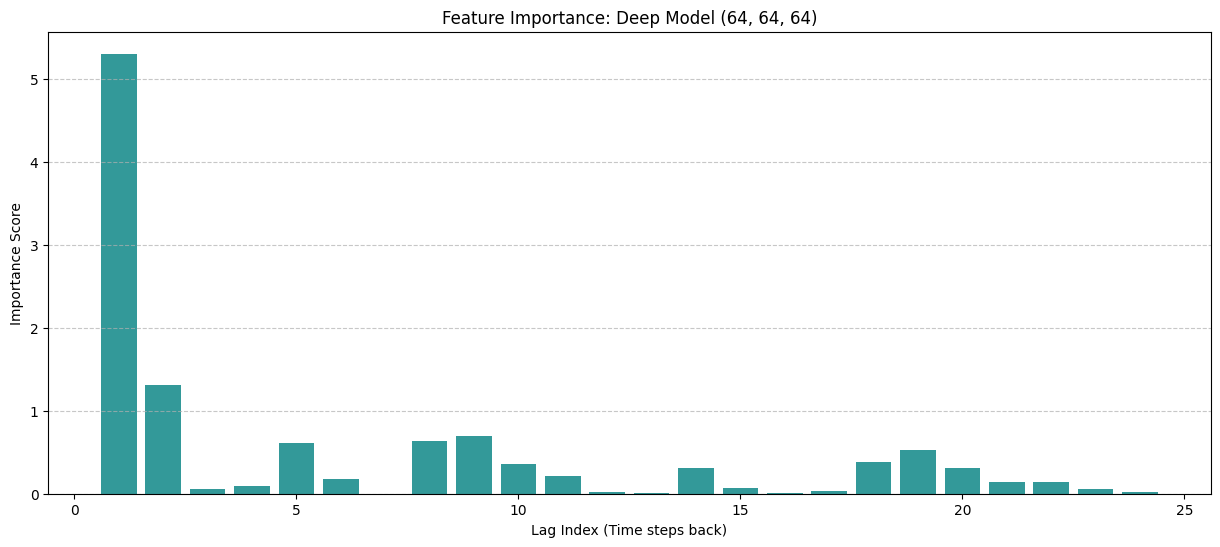

--- Top 5 Most Important Lags for Best Model ---
Feature 1 (Lag 1): Score 5.3015
Feature 2 (Lag 2): Score 1.3108
Feature 9 (Lag 9): Score 0.6931
Feature 8 (Lag 8): Score 0.6361
Feature 5 (Lag 5): Score 0.6093


In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize and Train the Best Model (Deep 64, 64, 64)
print("Training the Deep (64, 64, 64) model...")
best_model = MLPRegressor(hidden_layer_sizes=(64, 64, 64),
                          activation='relu',
                          solver='adam',
                          max_iter=500,
                          n_iter_no_change=20,
                          random_state=42)

best_model.fit(X_train_scaled, y_train_scaled.ravel())

# 2. Calculate Permutation Importance
# We use the test set to see how important features are for unseen data
print(f"Calculating importance for {X_test_scaled.shape[1]} features...")
result = permutation_importance(
    best_model, X_test_scaled[:5000], y_test_scaled[:5000],
    n_repeats=5, random_state=42, n_jobs=-1
)

# 3. Get and Plot the importance values
importances = result.importances_mean
num_features = len(importances)

plt.figure(figsize=(15, 6))
plt.bar(range(1, num_features + 1), importances, color='teal', alpha=0.8)

plt.title(f'Feature Importance: Deep Model (64, 64, 64)')
plt.xlabel('Lag Index (Time steps back)')
plt.ylabel('Importance Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('best_model_importance.png') # This will save the plot
plt.show()

# 4. Print the Top 5 Most Important Lags
top_indices = np.argsort(importances)[::-1][:5]
print("--- Top 5 Most Important Lags for Best Model ---")
for idx in top_indices:
    # Note: If your data is hourly (from Cell 0 resample), each lag is 60 mins.
    # The original notebook used 15 mins in the print statement, adjust as needed.
    print(f"Feature {idx+1} (Lag {idx+1}): Score {importances[idx]:.4f}")

Training the Deep (64, 64, 64) model...
Calculating importance for 24 features...


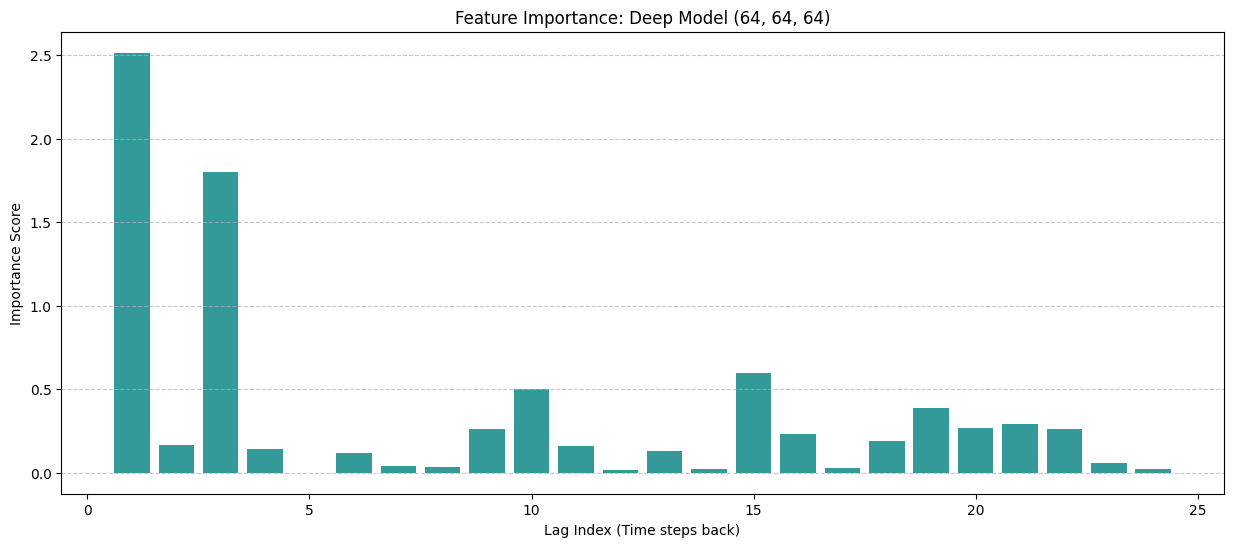

--- Top 5 Most Important Lags for Best Model ---
Feature 1 (Lag 1): Score 2.5149
Feature 3 (Lag 3): Score 1.8028
Feature 15 (Lag 15): Score 0.5976
Feature 10 (Lag 10): Score 0.4993
Feature 19 (Lag 19): Score 0.3849


In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize and Train the Best Model (Deep 64, 64, 64)
print("Training the Deep (64, 64, 64) model...")
best_model = MLPRegressor(hidden_layer_sizes=(32),
                          activation='relu',
                          solver='adam',
                          max_iter=500,
                          n_iter_no_change=20,
                          random_state=42)

best_model.fit(X_train_scaled, y_train_scaled.ravel())

# 2. Calculate Permutation Importance
# We use the test set to see how important features are for unseen data
print(f"Calculating importance for {X_test_scaled.shape[1]} features...")
result = permutation_importance(
    best_model, X_test_scaled[:5000], y_test_scaled[:5000],
    n_repeats=5, random_state=42, n_jobs=-1
)

# 3. Get and Plot the importance values
importances = result.importances_mean
num_features = len(importances)

plt.figure(figsize=(15, 6))
plt.bar(range(1, num_features + 1), importances, color='teal', alpha=0.8)

plt.title(f'Feature Importance: Deep Model (64, 64, 64)')
plt.xlabel('Lag Index (Time steps back)')
plt.ylabel('Importance Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('best_model_importance.png') # This will save the plot
plt.show()

# 4. Print the Top 5 Most Important Lags
top_indices = np.argsort(importances)[::-1][:5]
print("--- Top 5 Most Important Lags for Best Model ---")
for idx in top_indices:
    # Note: If your data is hourly (from Cell 0 resample), each lag is 60 mins.
    # The original notebook used 15 mins in the print statement, adjust as needed.
    print(f"Feature {idx+1} (Lag {idx+1}): Score {importances[idx]:.4f}")